# Hotel Bar Inventory Forecasting & Recommendation System

This notebook provides an end-to-end solution for forecasting item-level demand and recommending optimal inventory (par) levels for a hotel chain's bars, using historical inventory movement data.  
We will also simulate how the system would function in practice and visualize demand vs. par level.

## 1. Import Libraries

I am using  pandas for data manipulation, numpy for calculations, matplotlib for visualization, and statsmodels for time series forecasting.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data and Data Exploration



In [2]:
# Load the dataset
file_path = 'Consumption Dataset - Dataset.csv'
df = pd.read_csv(file_path)
df.head()

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,1/1/2023 19:35,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,1/1/2023 10:07,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,1/1/2023 11:26,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28
3,1/1/2023 13:53,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53
4,1/1/2023 22:28,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90


In [3]:
# Check the dataset
print('Dataset shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nMissing values per column:')
print(df.info())
print(df.isnull().sum())



Dataset shape: (6575, 8)

Columns: ['Date Time Served', 'Bar Name', 'Alcohol Type', 'Brand Name', 'Opening Balance (ml)', 'Purchase (ml)', 'Consumed (ml)', 'Closing Balance (ml)']

Missing values per column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time Served      6575 non-null   object 
 1   Bar Name              6575 non-null   object 
 2   Alcohol Type          6575 non-null   object 
 3   Brand Name            6575 non-null   object 
 4   Opening Balance (ml)  6575 non-null   float64
 5   Purchase (ml)         6575 non-null   float64
 6   Consumed (ml)         6575 non-null   float64
 7   Closing Balance (ml)  6575 non-null   float64
dtypes: float64(4), object(4)
memory usage: 411.1+ KB
None
Date Time Served        0
Bar Name                0
Alcohol Type            0
Brand Name              0
Opening Balan

## 3. Data Processing

In this cell Parsing date columns, handling of missing values and aggregate demand per item per day is performed 



In [4]:
# Parse date and basic cleaning
df['Date'] = pd.to_datetime(df['Date Time Served']).dt.date
df['Consumed (ml)'] = pd.to_numeric(df['Consumed (ml)'], errors='coerce').fillna(0)

# Aggregate daily demand per Bar, Alcohol Type, Brand
daily_demand = df.groupby(['Date', 'Bar Name', 'Alcohol Type', 'Brand Name'])['Consumed (ml)'].sum().reset_index()
daily_demand.head()

,Date,Bar Name,Alcohol Type,Brand Name,Consumed (ml)
0,2023-01-01,Anderson's Bar,Beer,Miller,0.0
1,2023-01-01,Anderson's Bar,Rum,Bacardi,0.0
2,2023-01-01,Anderson's Bar,Whiskey,Jim Beam,0.0
3,2023-01-01,Anderson's Bar,Wine,Sutter Home,0.0
4,2023-01-01,Brown's Bar,Rum,Captain Morgan,0.0


## 4. Forecasting Demand for All Bars

We will forecast demand for each item (Bar, Alcohol Type, Brand) using a simple moving average as a baseline.  


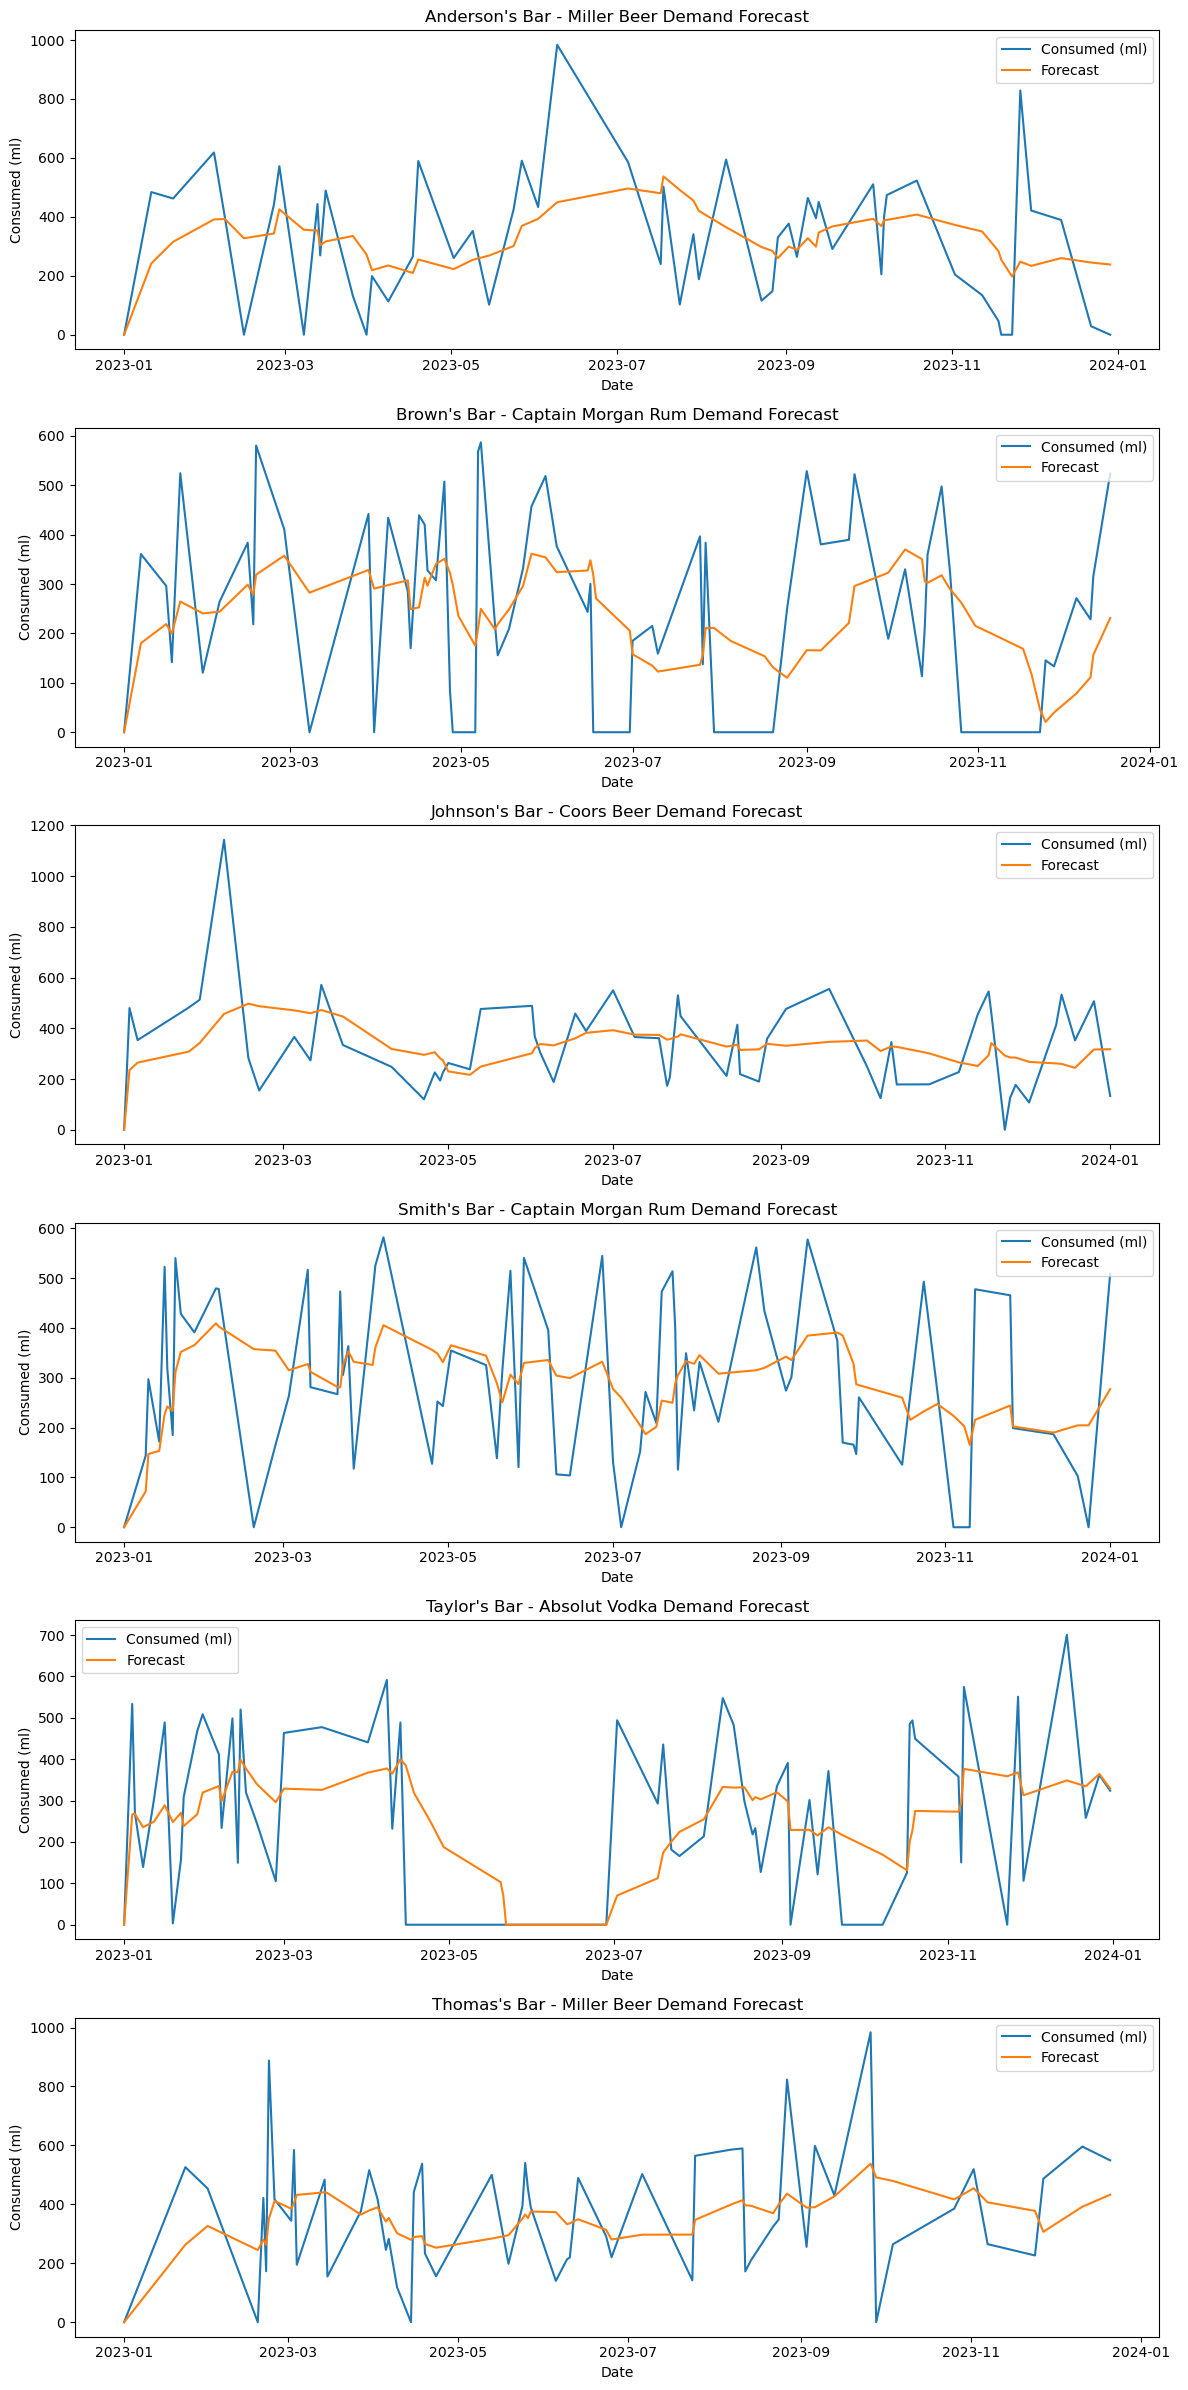

In [5]:
# Forecast and plot for one item from each bar
bars = daily_demand['Bar Name'].unique()
plt.figure(figsize=(12, 4 * len(bars)))
for i, bar in enumerate(bars, 1):
    # Take the first available item (brand/type) for each bar
    sub = daily_demand[daily_demand['Bar Name'] == bar]
    if sub.empty:
        continue
    # Pick the first combination of Alcohol Type and Brand Name
    row = sub.iloc[0]
    alcohol_type = row['Alcohol Type']
    brand = row['Brand Name']
    item = sub[(sub['Alcohol Type'] == alcohol_type) & (sub['Brand Name'] == brand)].copy()
    item = item.set_index('Date').sort_index()
    # Simple moving average forecast (last 7 days)
    item['Forecast'] = item['Consumed (ml)'].rolling(window=7, min_periods=1).mean()
    plt.subplot(len(bars), 1, i)
    item[['Consumed (ml)', 'Forecast']].plot(ax=plt.gca(), title=f"{bar} - {brand} {alcohol_type} Demand Forecast")
    plt.ylabel('Consumed (ml)')
    plt.xlabel('Date')
    plt.legend()
plt.tight_layout()
plt.show()

## 5. Inventory Recommendation (Par Level)

Par Level = (Average Daily Demand × Lead Time) + Safety Stock  
- Assume lead time = 3 days  
- Safety stock = 1.5 × std deviation of daily 


Recommended par level for one item from each bar is calculated

In [6]:
# Calculate recommended par level for one item from each bar
par_level_examples = []
bars = daily_demand['Bar Name'].unique()
for bar in bars:
    sub = daily_demand[daily_demand['Bar Name'] == bar]
    if sub.empty:
        continue
    # Pick the first available item (brand/type) for each bar
    row = sub.iloc[0]
    alcohol_type = row['Alcohol Type']
    brand = row['Brand Name']
    item = sub[(sub['Alcohol Type'] == alcohol_type) & (sub['Brand Name'] == brand)]
    avg = item['Consumed (ml)'].mean()
    std = item['Consumed (ml)'].std()
    lead_time = 3
    safety_mult = 1.5
    par_level = avg * lead_time + safety_mult * std
    par_level_examples.append({
        'Bar Name': bar,
        'Alcohol Type': alcohol_type,
        'Brand Name': brand,
        'Recommended Par Level (ml)': par_level
    })
par_level_df = pd.DataFrame(par_level_examples)
par_level_df

,Bar Name,Alcohol Type,Brand Name,Recommended Par Level (ml)
0,Anderson's Bar,Beer,Miller,1307.349417
1,Brown's Bar,Rum,Captain Morgan,1004.798811
2,Johnson's Bar,Beer,Coors,1268.429824
3,Smith's Bar,Rum,Captain Morgan,1128.517876
4,Taylor's Bar,Vodka,Absolut,1075.599842
5,Thomas's Bar,Beer,Miller,1424.733929


## 6. Generalize: Recommend Par Levels for All Items

The  recommended par levels for all items  are shown.

In [7]:
# Calculate par level for each items of each bar
def calc_par_level(group, lead_time=3, safety_mult=1.5):
    avg = group['Consumed (ml)'].mean()
    std = group['Consumed (ml)'].std()
    return avg * lead_time + safety_mult * std

par_levels = daily_demand.groupby(['Bar Name', 'Alcohol Type', 'Brand Name']).apply(calc_par_level).reset_index()
par_levels.columns = ['Bar Name', 'Alcohol Type', 'Brand Name', 'Recommended Par Level (ml)']
par_levels.head(20)

,Bar Name,Alcohol Type,Brand Name,Recommended Par Level (ml)
0,Anderson's Bar,Beer,Budweiser,920.629663
1,Anderson's Bar,Beer,Coors,1294.884738
2,Anderson's Bar,Beer,Heineken,1178.323196
3,Anderson's Bar,Beer,Miller,1307.349417
4,Anderson's Bar,Rum,Bacardi,1301.828008
5,Anderson's Bar,Rum,Captain Morgan,1406.276693
6,Anderson's Bar,Rum,Malibu,976.550924
7,Anderson's Bar,Vodka,Absolut,831.707038
8,Anderson's Bar,Vodka,Grey Goose,1293.119999
9,Anderson's Bar,Vodka,Smirnoff,1298.122233


## 7. Simulation: How Would This System Perform?

Simulate inventory management for a sample item and visualize demand vs. par level for one item of each bar.

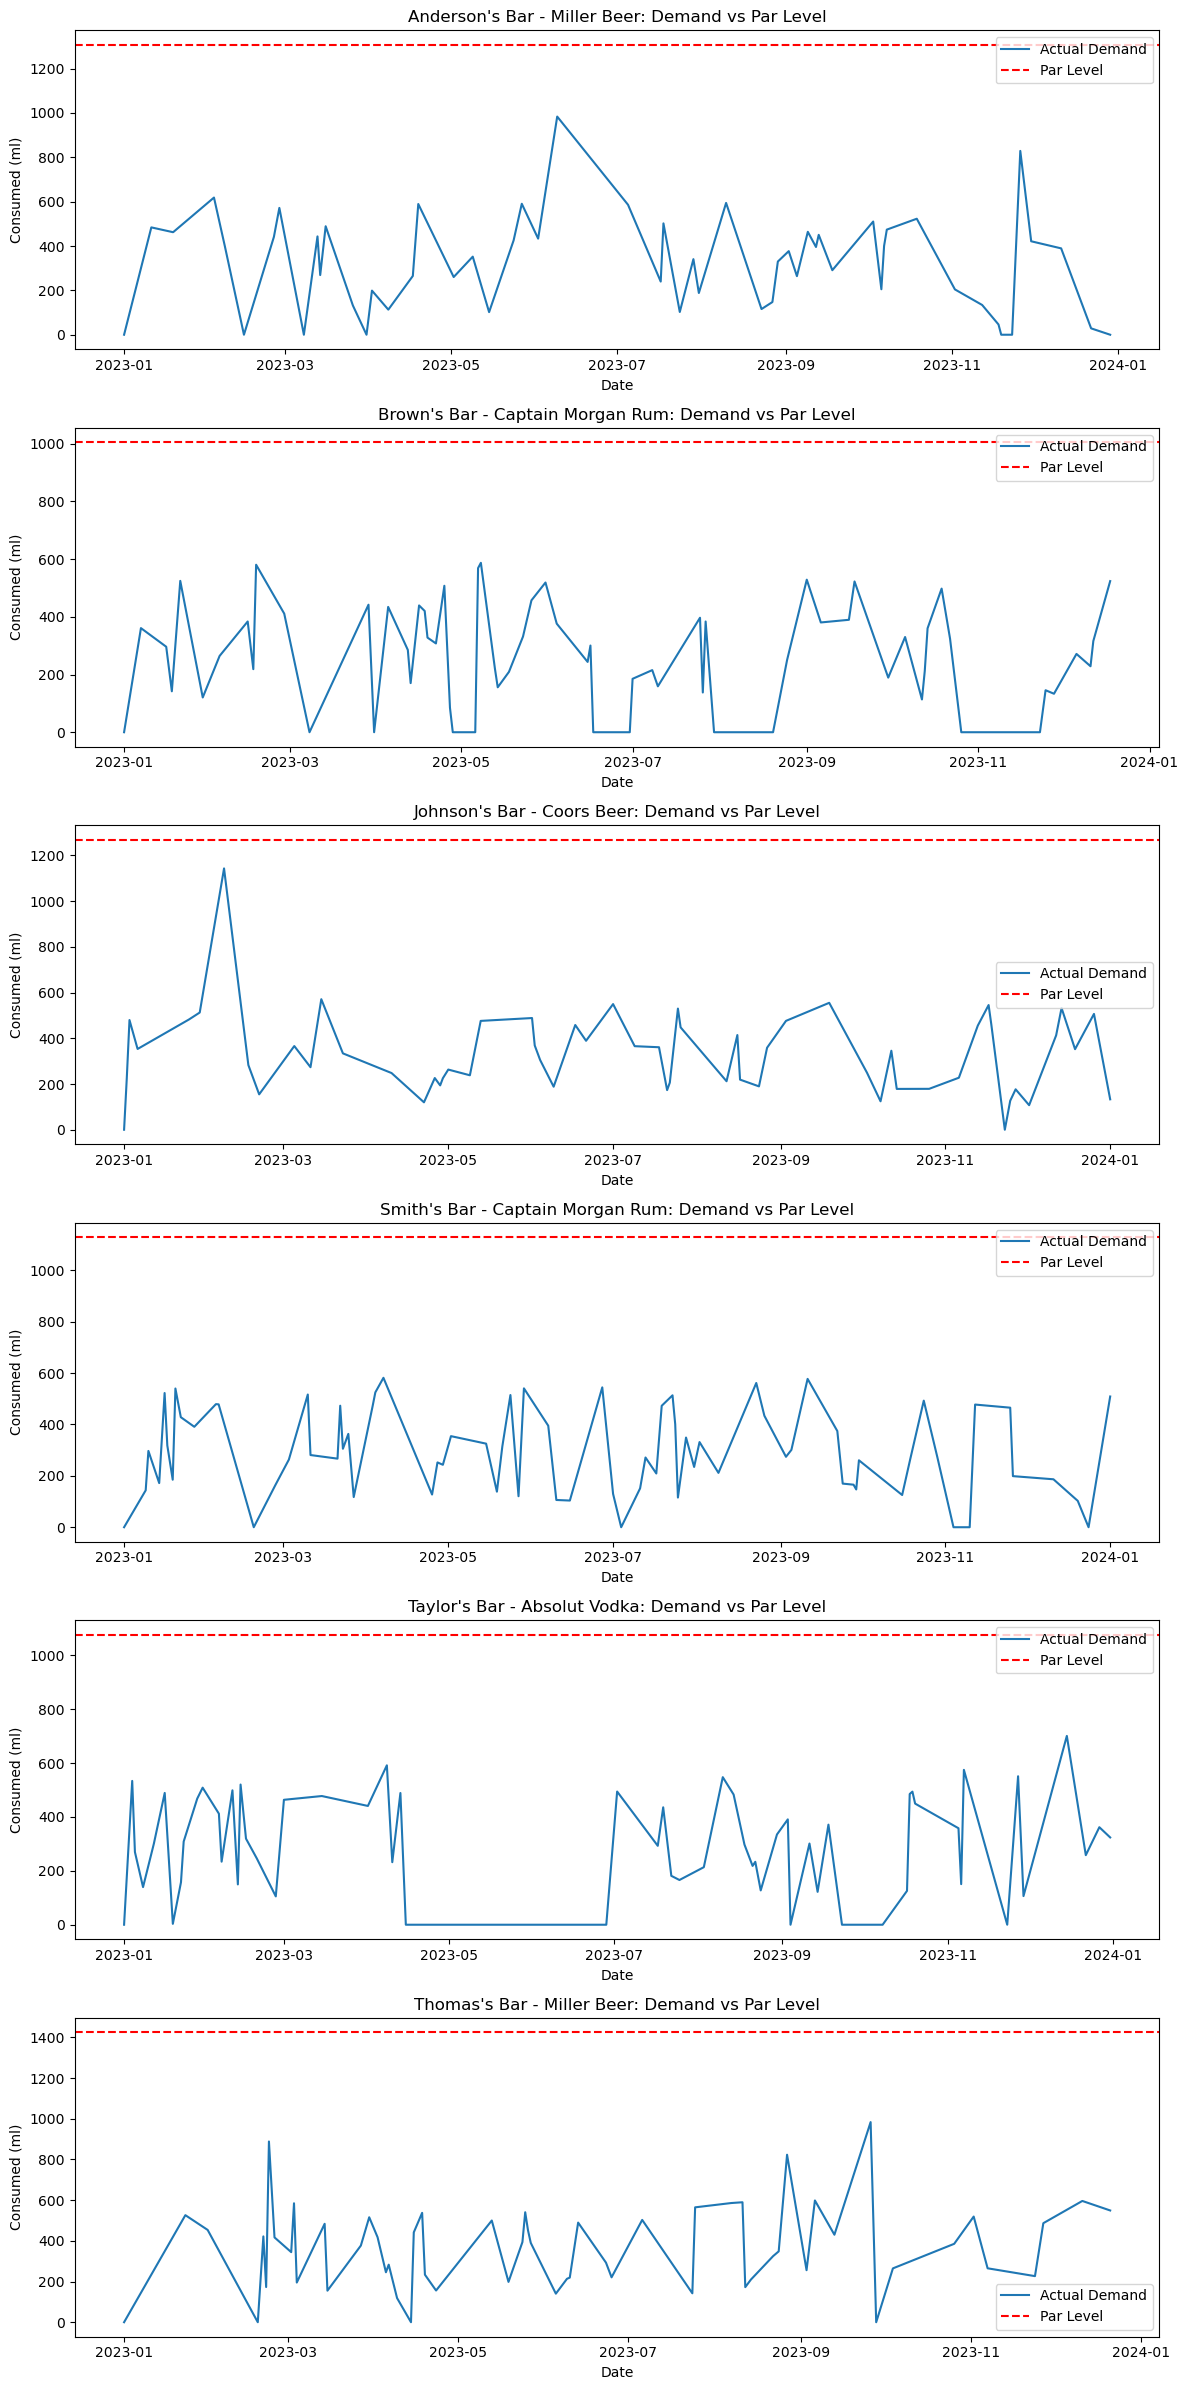

In [9]:
# Merge daily demand with recommended par levels for simulation
sim_data = pd.merge(
    daily_demand,
    par_levels,
    on=['Bar Name', 'Alcohol Type', 'Brand Name'],
    how='left'
)

# Simulate and plot demand vs par level for one item from each bar
plt.figure(figsize=(12, 4 * len(bars)))
for i, bar in enumerate(bars, 1):
    row = daily_demand[daily_demand['Bar Name'] == bar].iloc[0]
    alcohol_type = row['Alcohol Type']
    brand = row['Brand Name']
    sample = sim_data[(sim_data['Bar Name'] == bar) & \
                     (sim_data['Alcohol Type'] == alcohol_type) & \
                     (sim_data['Brand Name'] == brand)].copy()
    plt.subplot(len(bars), 1, i)
    plt.plot(sample['Date'], sample['Consumed (ml)'], label='Actual Demand')
    plt.axhline(y=sample['Recommended Par Level (ml)'].iloc[0], color='r', linestyle='--', label='Par Level')
    plt.title(f"{bar} - {brand} {alcohol_type}: Demand vs Par Level")
    plt.xlabel('Date')
    plt.ylabel('Consumed (ml)')
    plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

This notebook provides solution that helps hotel managers make better inventory decisions using data. It predicts how much of each item is likely to be needed and suggests how much to keep in stock. This way, it helps avoid running out of popular items and stops unnecessary overstocking. As a result, it saves money and keeps guests happy. With more improvements and automation, it can become a powerful tool for managing inventory across all hotel bars.